# Binary Logistic Regression

We will review the model you saw in **DSCI 561** called **Binary Logistic regression**. From now on, we will use the term "*binary*" to differentiate it from further generalized linear models (GLMs) covered in this course. That said, it is essential to highlight that Binary Logistic regression is the most basic GLM. 

Let us dig into this model by introducing an appropriate dataset.

## Loading Libraries

In [1]:
options(repr.plot.height = 9, repr.plot.width = 20, repr.matrix.max.rows = 6)
source("../scripts/support_functions.R")
library(tidyverse)
library(mlbench)
library(AER)
library(cowplot)
library(broom)
library(performance)
library(qqplotr)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following

## 1. The Breast Cancer Dataset


The data frame `breast_cancer` is the Wisconsin Diagnostic Breast Cancer dataset ([Mangasarian et al., 1995](https://www.jstor.org/stable/171686)). It has a **binary** response `target`: **whether the tumour is `benign` or `malignant`**.

```{admonition} The Breast Cancer Dataset
This training dataset contains  569 observations from a digitized image of a fine needle aspirate (FNA) of a breast mass. The dataset details 30 real-valued characteristics (i.e., continuous regressors) plus the binary response and `ID` number. We will start working with the response `target` subject to the regressor `mean_radius`.
```

In [2]:
breast_cancer <- suppressWarnings(suppressMessages(read_csv("../datasets/breast_cancer.csv")))

breast_cancer_binary <- breast_cancer %>%
  dplyr::select(mean_radius, target)
breast_cancer_binary

mean_radius,target
<dbl>,<chr>
17.99,malignant
20.57,malignant
19.69,malignant
⋮,⋮
16.60,malignant
20.60,malignant
7.76,benign


```{admonition} Main Statistical Inquiries
Let us suppose we want to assess the following:

- Whether `target` and `mean_radius` are statistically associated and by how much. 
- Whether `target` and `mean_texture` are statistically associated and by how much.
```

## 2. Data Modelling Framework

We will set our binary response $Y_i$ mathematically as:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th tumour is malignant},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

The "1" category is referred as **success**. 

Note each $Y_i$ is a **Bernoulli** trial whose **probability of success** is $p_i$: 

$$Y_i \sim \text{Bernoulli}(p_i).$$

### 2.1. Using Ordinary Least-Squares to Model Probabilities 

We will take a "*naive*" approach to address our above main statistical inquiries. Suppose we use the "1" and "0" in the response as probabilities, and we estimate an ordinary least-squares (OLS) regression model to predict the mean of $Y_i$ subject to `mean_radius`, $X_{\texttt{mr}_i}$: 

$$
\mathbb{E}(Y_i \mid X_{\texttt{mr}_i}) = p_i = \beta_0 + \beta_1 X_{\texttt{mr}_i}
$$

The code below transforms the response `target`, via `mutate()`, as a probability with two possible outcomes: `1` for `malignant` and `0` for `benign`.

In [3]:
breast_cancer_binary <- breast_cancer_binary %>% 
  mutate(target = if_else(target == "malignant", 1, 0))
breast_cancer_binary

mean_radius,target
<dbl>,<dbl>
17.99,1
20.57,1
19.69,1
⋮,⋮
16.60,1
20.60,1
7.76,0


Thus, the plot below shows two subsets of points located on two horizontal lines. Note that those tumours classified as malignant (`1` on the $y$-axis) tend to have a larger `mean_radius.`

```{important} 
The OLS-fitted values of the 569 observations, with `mean_radius` as a regressor, are shown on the blue line. Recall that a probability cannot be negative or larger than $1$. Nonetheless, values larger than $20$ for `mean_radius` generate predictions larger than $1$, which is absurd for a probability. Moreover, small values of `mean_radius` generate predictions of less than $0$, which again does not make sense!
```

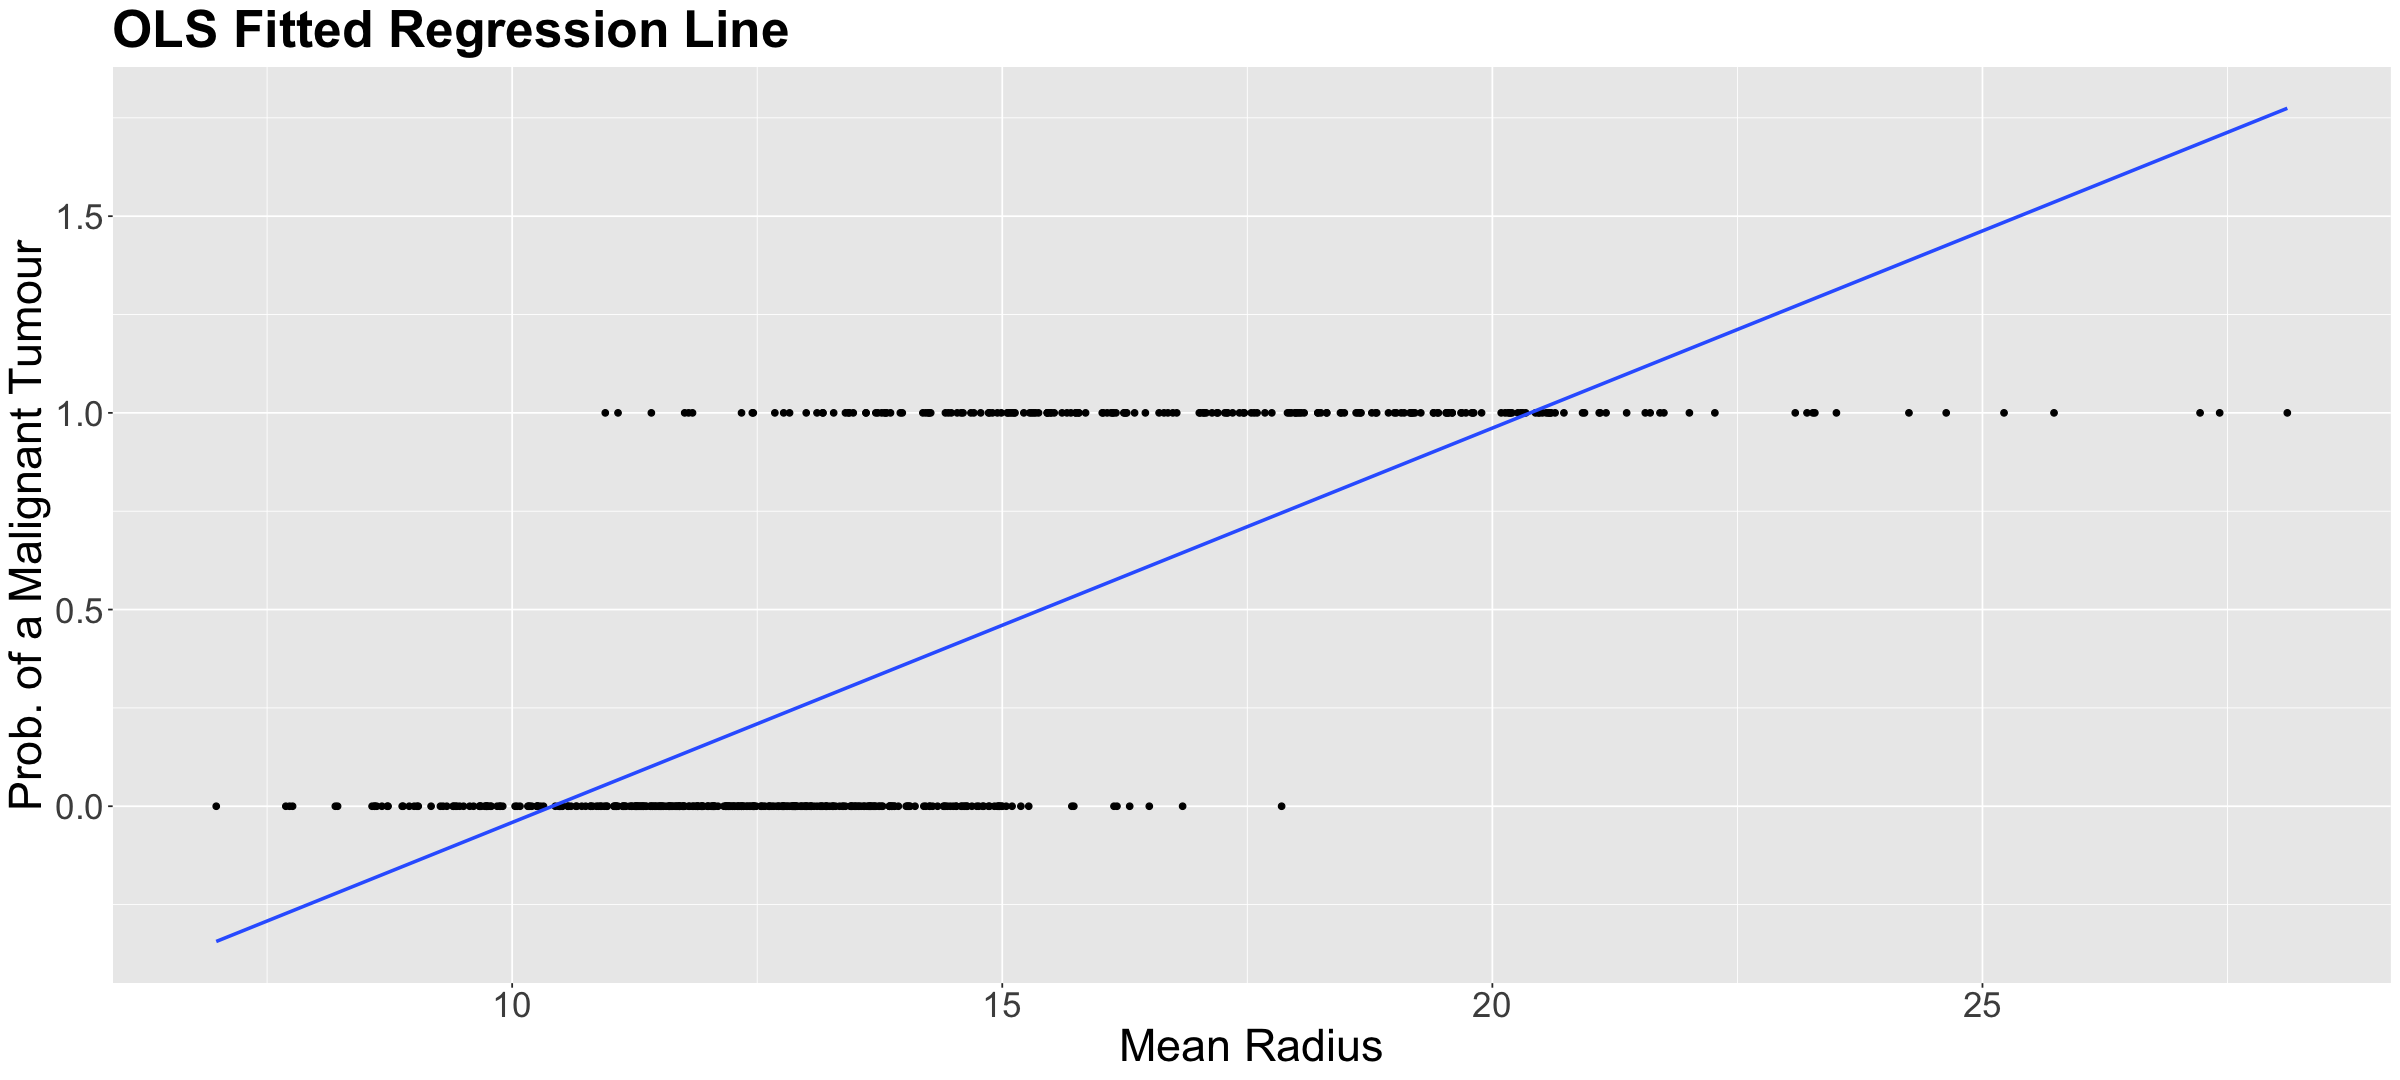

In [4]:
breast_cancer_plot <- breast_cancer_binary %>%
  ggplot() +
  geom_point(aes(mean_radius, target)) +
  geom_smooth(aes(mean_radius, target),
    method = "lm", formula = y ~ x, se = FALSE
  ) +
  labs(y = "Prob. of a Malignant Tumour", x = "Mean Radius") +
  ggtitle("OLS Fitted Regression Line") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) 
breast_cancer_plot

### 2.2. The Logit Function

Now, we might wonder: 

> Is there a way to overcome the above out-of-range issue?

Of course, there is a way involving a link function as explained in {ref}`link-function`. Nonetheless, a simple logarithmic transformation will not save the day here since we have $Y_i$ values equal to zero. Therefore, let us play around with the distribution theory from [**DSCI 551**](https://pages.github.ubc.ca/MDS-2023-24/DSCI_551_stat-prob-dsci_students/notes/appendix-dist-cheatsheet.html#bernoulli). Recall these facts:

```{math}
\begin{gather*}
Y_i \sim \text{Bernoulli}(p_i) \\
\mathbb{E}(Y_i) = p_i.
\end{gather*}
```

Given that the **mean** of a Bernoulli random variable $Y_i$ is $p_i$ under this modelling framework, we can establish the following link function (which is [**monotonic and differentiable**](link-function)):

$$
h(p_i) = \mbox{logit}(p_i)= \log\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i}.
$$ (eq-logit)

```{admonition} Definition of the Logit Function
:class: tip
The link function {eq}`eq-logit` is called the **logarithm of the odds** or **logit function**. This logit function $\log\left(\frac{p_i}{1 - p_i}\right)$ covers the entire real line, which solves the out-of-range problem from OLS in this case.
```

As a link function, the logit function is **monotonic**. Hence, how can we transform back $h(p_i)$ to the probability $p_i$? With some algebraic arrangements, we can come up with the following expression:

$$
p_i = \frac{\exp \left( \beta_0 + \beta_1 X_{\texttt{mr}_i} \right) }{ \left[ 1 + \exp \left( \beta_0 + \beta_1 X_{\texttt{mr}_i} \right) \right] } \in [0,1].
$$

Note that this whole modelling framework via this link function is called **Binary Logistic regression**.

The plot below fits this **simple** (we only have one regressor!) Binary Logistic regression using `breast_cancer_binary` with `target` as a response and `mean_radius` as a regressor. We can do this via `geom_smooth()` using `method = "glm"` and `method.args = c(family = binomial)`. 

Then, we obtain the **in-sample predictions** 

$$\hat{p_i} = \frac{\exp \left( \hat{\beta}_0 + \hat{\beta}_1 x_{\texttt{mr}_i} \right) }{ \left[ 1 + \exp \left( \hat{\beta}_0 + \hat{\beta}_1 x_{\texttt{mr}_i} \right) \right] } \in [0,1].$$

and connect them as a red line. This red $S$-shaped function above is called the **sigmoid function**. Note this function covers all the real line of `mean_radius` but it is constrained between 0 and 1 for the probability of encountering a malignant tumour.

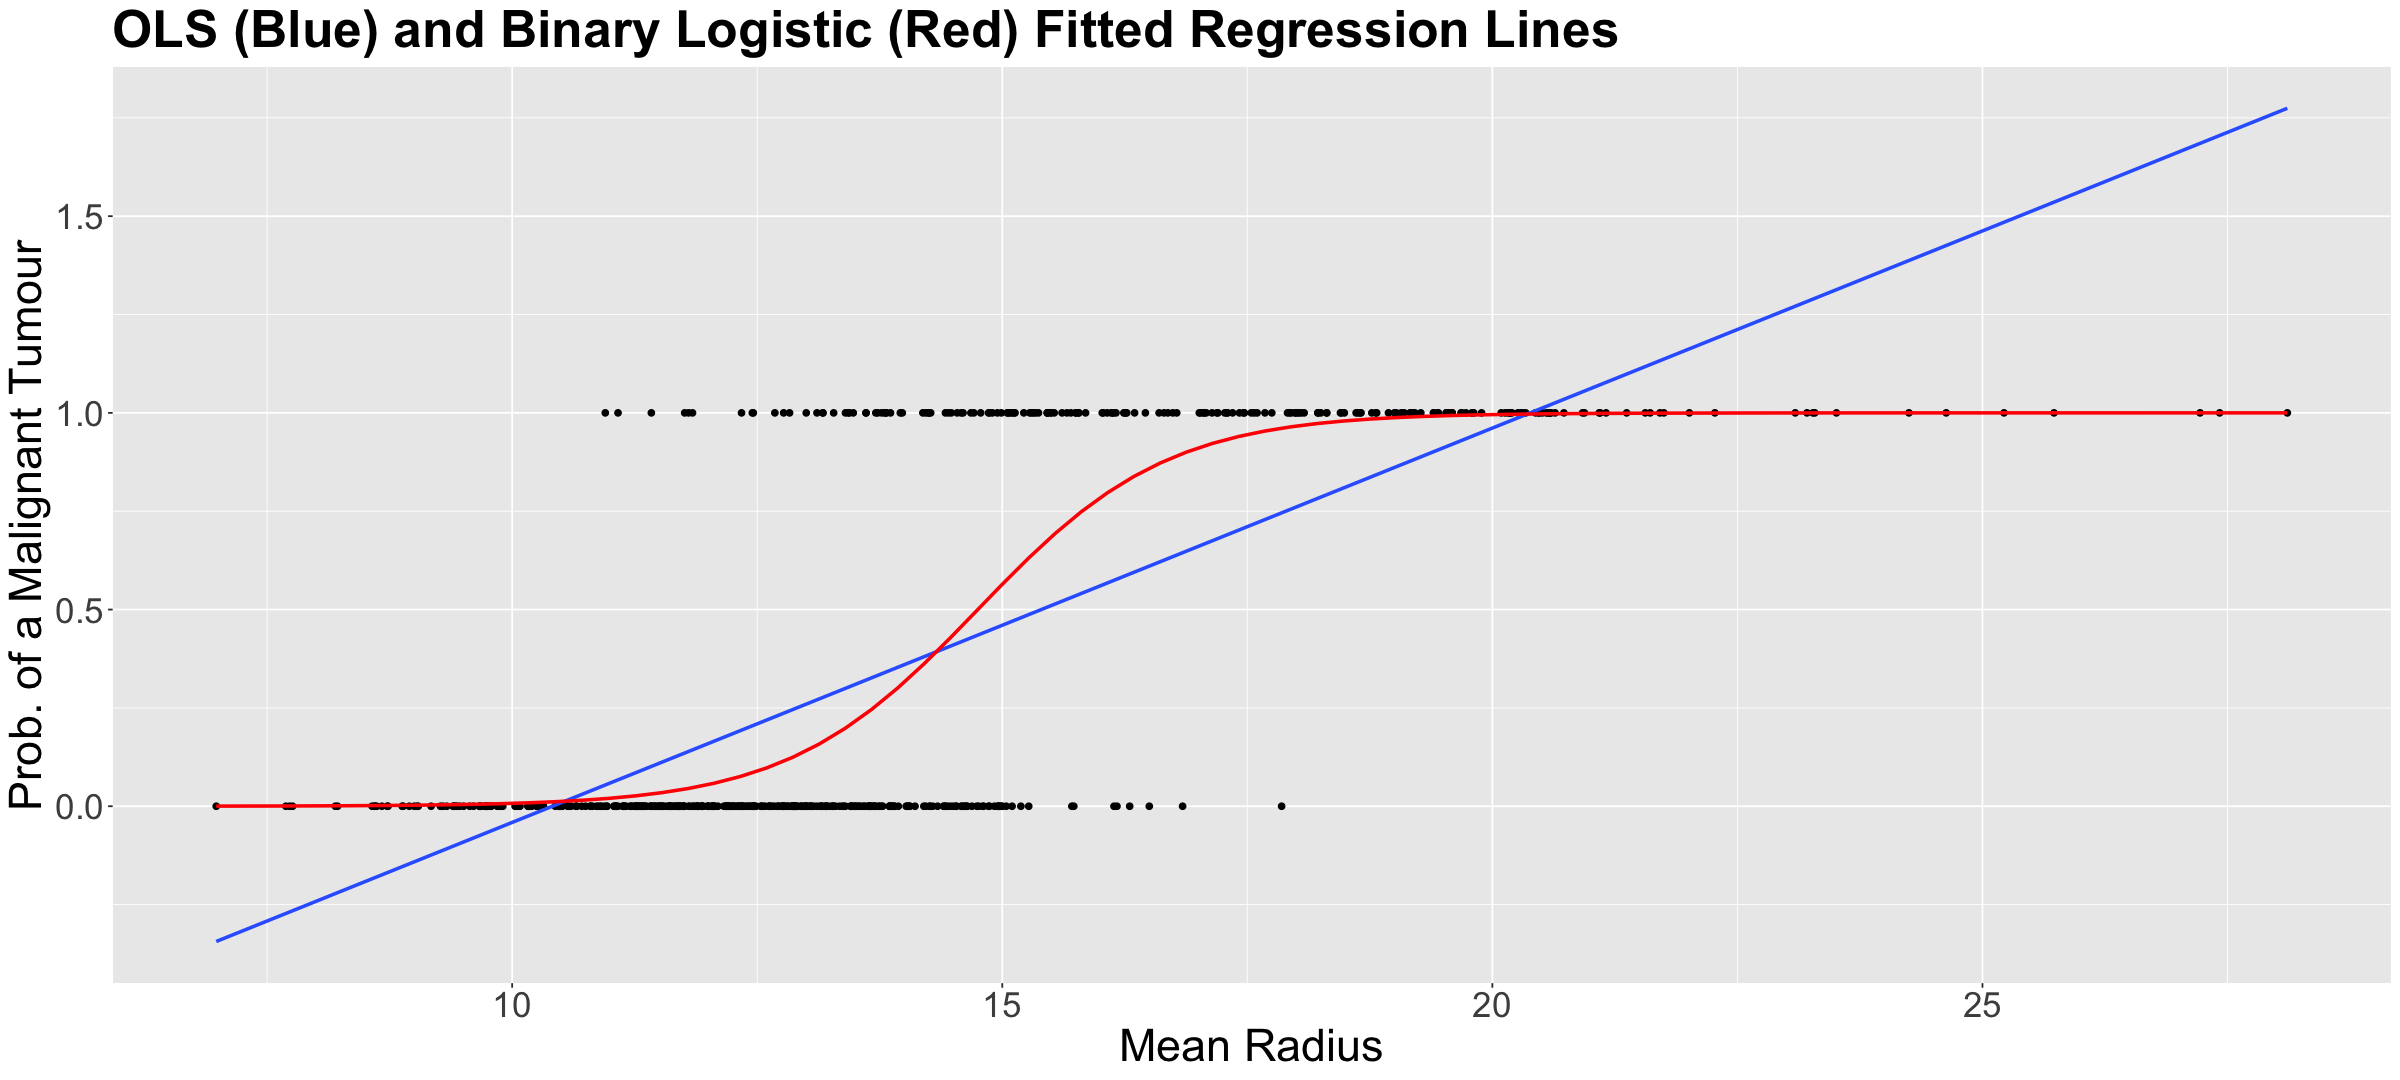

In [5]:
breast_cancer_plot <- breast_cancer_plot +
  geom_smooth(aes(mean_radius, target),
    method = "glm", formula = y ~ x,
    method.args = c(family = binomial), se = FALSE, color = "red"
  ) +
  ggtitle("OLS (Blue) and Binary Logistic (Red) Fitted Regression Lines")
breast_cancer_plot

### 2.3. General Modelling Framework

The Binary Logistic regression model has a response variable in the form:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th observation is a success},\\
0 \; \; \; \; \mbox{otherwise.}
\end{cases}
$$

As the response variable can only take the values $0$ or $1$, the key parameter becomes the probability that $Y_i$ takes on the value of $1$, i.e. the probability of success, denoted as $p_i$. Hence:

$$
Y_i \sim \text{Bernoulli}(p_i).
$$

The Binary Logistic regression approach models the probability of success, $p_i$, of the binary response $Y_i$. To re-express $p_i$ **on an unrestricted scale**, the modelling is done in terms of the logit function (the link function in this model).

Specifically, for a training set of size $n$, $p_i$ ($i = 1, 2, \dots, n$) will depend on the values of the $k$ regressors $X_{i, 1}, X_{i, 2}, \dots, X_{i, k}$ in the form:

$$
h(p_i) = \mbox{logit}(p_i) = \log \left( \frac{p_i}{1 - p_i} \right) = \beta_0 + \beta_1 X_{i, 1} + \beta_1 X_{i, 2} + \ldots + \beta_k X_{i, k},
$$

or equivalently

$$
p_i = \frac{\exp \left[ \mbox{logit} (p_i) \right]}{1 + \exp \left[ \mbox{logit}(p_i) \right]}.
$$

Note that the $\log(\cdot)$ notation in the model above refers to the **natural logarithm**, i.e., **logarithm base $e$**. The equation above for $p_i$ shows that this Binary Logistic regression model will result in values of the probability of success $p_i$ that are always between 0 and 1. 

```{important}
The response in this GLM is called the log-odds, the logarithm of the odds 

$$\frac{p_i}{1 - p_i},$$

the ratio of the probability of the event to the probability of the non-event. For instance, if the event is that the tumour is malignant, the odds denote how likely the $i$th tumour is to be malignant compared to how unlikely it is. The coefficient $\beta_j$ ($j = 1, \dots, k$) denotes how much the log-odds increases or decreases when the corresponding continuous regressor changes by one unit.
```

## 3. Estimation

Under a general framework with $k$ regressors, the **regression parameters** $\beta_0, \beta_1, \dots, \beta_k$ in this model are also unknown. In order to fit the model, we can use the function `glm()` and its argument `family = binomial` (required to specify the binary nature of the response), which obtains the estimates $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_k$ (note the hat notation).

The estimates are obtained through **maximum likelihood** where we assume a **joint probability mass function of the $n$ responses $Y_i$**.

```{important}
For the sake of coding clarity, you could also use `family = binomial(link = "logit")`. Nevertheless, `link = "logit"` is a default in `glm()` for Binary Logistic regression. Thus, `family = binomial` suffices when using the logit function.
```

In [6]:
binary_log_model <- glm(as.factor(target) ~ mean_radius,
  data = breast_cancer_binary, family = binomial
)

## 4. Inference

We can determine **whether a regressor is statistically associated with the logarithm of the response's odds** through **hypothesis testing** for the parameters $\beta_j$. We will need information about the estimated regression coefficient $\hat{\beta}_j$ and its corresponding variability which is reflected in the **standard error** of the estimate, $\mbox{se} \left( \hat{\beta}_j \right)$.

To determine the **statistical significance** of $\hat{\beta}_j$, you can use the **Wald statistic**

$$
z_j = \frac{\hat{\beta}_j}{\mbox{se} \left( \hat{\beta}_j \right)}
$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j = 0 \\
H_a: \beta_j \neq 0.
\end{gather*}
```

**A statistic like $z_j$ is analogous to the $t$-value in OLS regression.** However, in Binary Logistic regression, provided the sample size $n$ is large enough, $z_j$ has an **approximately Standard Normal distribution** under $H_0$ rather than a $t$-distribution.


`R` provides the corresponding **$p$-value** for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. Hence, a small enough $p$-value (less than the significance level $\alpha$) indicates that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the log-dds and the $j$th regressor. Furthermore, given a specified level of confidence, we can construct approximate $(1 - \alpha) \times 100\%$ **confidence intervals** (CIs) for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se} \left( \hat{\beta}_j \right),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the **Standard Normal distribution**.

Now, we can answer the following: 

> Is `mean_radius` statistically associated with the logarithm of the odds of `target`?

We can also use the function `tidy()` from the `broom` package along with argument `conf.int = TRUE` to get the 95% confidence intervals **by default**.

In [7]:
tidy(binary_log_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-15.246,1.325,-11.510,0,-18.034,-12.826
mean_radius,1.034,0.093,11.101,0,0.864,1.230


Our sample gives us evidence to reject $H_0$ ($p\text{-value} < .001$). So `mean_radius` is statistically associated to the logarithm of the odds of `target`.

## 5. Coefficient Interpretation

> What is the interpretation of the estimate $\hat{\beta}_1$ for `mean_radius` on the response `target`?

We have to transform back our estimated coefficient $\hat{\beta_1}$ to the original scale of the odds $\frac{p_i}{1 - p_i}$. Function `tidy()` has the handy argument `exponentiate = TRUE` which exponentiates the `estimate` column along with the CIs (note the rest of the columns remain untransformed).

In [8]:
tidy(binary_log_model, conf.int = TRUE, exponentiate = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,1.32,-11.51,0,0.00,0.00
mean_radius,2.81,0.09,11.10,0,2.37,3.42


The interpretation is: 

> For each unit increase in `mean_radius`, the tumour is 2.81 times more likely to be malignant than to be benign.

This example does not provide interpretations for **categorical explanatory variables**. That said, as in OLS multiple regression, the model would estimate multiple regression coefficients for that categorical explanatory variable: one for each level other than the **baseline level**. The interpretation of each estimated regression coefficient will depend on which category is specified as the baseline category. 

Recall {numref}`dummy-var`, which describes dummy variables for a nominal explanatory variable with $u$ categories, where **Level 1** was specified as the baseline level, so all $u - 1$ dummy variables are zero for that level. The estimated regression coefficient for **Level 2** represents how much the log-odds increases or decreases compared to the baseline category. The same interpretation applies to the regression coefficients for levels $3, \dots, u$. If we want to interpret these coefficients on the original scale of the odds $\frac{p_i}{1 - p_i}$, then we exponentiate each one of these estimated coefficients.

Now, let us fit a second model with two regressors: `mean_radius` ($X_{\texttt{mr}_i}$) and `mean_texture` ($X_{\texttt{mt}_i}$) for the $i$th observation:

$$
\eta_i = \mbox{logit}(p_i)= \log\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i} + \beta_2 X_{\texttt{mt}_i}.
$$

Firstly, we select the necessary columns from our dataset `breast_cancer`.

In [9]:
breast_cancer_binary_2 <- breast_cancer %>%
  dplyr::select(mean_radius, mean_texture, target)
breast_cancer_binary_2

mean_radius,mean_texture,target
<dbl>,<dbl>,<chr>
17.99,10.38,malignant
20.57,17.77,malignant
19.69,21.25,malignant
⋮,⋮,⋮
16.60,28.08,malignant
20.60,29.33,malignant
7.76,24.54,benign


Then, we fit the corresponding Binary Logistic regression.

In [10]:
binary_log_model_2 <- glm(as.factor(target) ~ mean_radius + mean_texture,
  data = breast_cancer_binary_2, family = binomial)
tidy(binary_log_model_2, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-19.849,1.774,-11.189,0,-23.592,-16.615
mean_radius,1.057,0.101,10.417,0,0.872,1.271
mean_texture,0.218,0.037,5.885,0,0.147,0.293


Note that both regressors (`mean_radius` and `mean_texture`) are statistically significant for the response `target` ($p\text{-values} < .001$). Then, we make the corresponding coefficient interpretations:

In [11]:
tidy(binary_log_model_2, conf.int = TRUE, exponentiate = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,1.77,-11.19,0,0.00,0.00
mean_radius,2.88,0.10,10.42,0,2.39,3.57
mean_texture,1.24,0.04,5.89,0,1.16,1.34


The interpretation for `mean_radius` is: 

> For each unit increase in `mean_radius`, the tumour is 2.88 times more likely to be malignant than to be benign while holding `mean_texture` constant.

The interpretation for `mean_texture` is: 

> For each unit increase in `mean_texture`, the tumour is 1.24 times more likely to be malignant than to be benign while holding `mean_radius` constant."

```{important}
Note that the estimated coefficients for each regressor are standalone. Hence, we have to clarify that each estimate stands while holding the other regressor constant. This same interpretation holds with more than two regressors.
```

## 7. Predictions


Suppose we want to predict the odds of a tumour being malignant to being benign using our trained `binary_log_model_2`. This tumour has the following values for `mean_radius` and `mean_texture`: $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$, respectively.

We use `binary_log_model_2` for making such prediction as follows:

```{math}
\begin{gather*} 
\log \left( \frac{\hat{p}}{1 - \hat{p}} \right) = \underbrace{-19.849}_{\hat{\beta}_0} + \underbrace{1.057}_{\hat{\beta}_1}(16) + \underbrace{0.218}_{\hat{\beta}_2}(20) = 1.43 \\
\frac{\hat{p}}{1 - \hat{p}} = 4.17.
\end{gather*}
```

We can use the function `predict()` via the argument `type = "link"` to obtain the predicted logarithm of the odds. Then, we exponentiate it to get the predicted odds.

In [12]:
round(exp(predict(binary_log_model_2,
  tibble(mean_radius = 16, mean_texture = 20),
  type = "link"
)), 2)

1 
4.17

Hence, a tumour with $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$ is predicted to be 4.17 times more likely to be malignant than benign.

**Can We Predict Probabilities For Classification Purposes?**

Using the function `predict()` via the argument `type = "response"` with the object `binary_log_model_2`, we can obtain the estimated probability for a tumour to be malignant with the following values for `mean_radius` and `mean_texture`: $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$ respectively.

In [13]:
round(predict(binary_log_model_2,
  tibble(mean_radius = 16, mean_texture = 20),
  type = "response"
), 2)

1 
0.81

Hence, a tumour with $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$ has a predicted probability of 0.81 of beign malignant.

(bin-log-model-selection)=
## 8. Model Selection

**To perform model selection**, let us recall our two Binary Logistic regression models with `target` as a response. **Model 1** will only have the continuous `mean_radius` ($X_{\texttt{mr}_i}$) as a regressor (i.e., `binary_log_model`), whereas **Model 2** will have `mean_radius` and `mean_texture` ($X_{\texttt{mr}_i}$ and $X_{\texttt{mt}_i}$) as regressors (i.e, `binary_log_model_2`).

```{math}
\begin{align*}
\textbf{Model 1:} & \\ 
& h(p_i) = \log\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i}. \\
\textbf{Model 2:} & \\ 
& h(p_i) = \log\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i} + \beta_2 X_{\texttt{mt}_i}.
\end{align*}
```

Since we are digging into model selection, we want to determine which Binary Logistic regression model fits the data better: **Model 1** or **Model 2**. Let us explore some selection techniques.

### 8.1. Analysis of Deviance

The **deviance** ($D_k$) criterion can be used to compare a given model with $k$ regressors with that of a **baseline model**. The usual baseline model is the **saturated** or **full model**, which perfectly fits the data because it allows a distinct probability of success $p_i$ for the $i$th observation in the training dataset ($i = 1, \dots, n$), **unrelated to the $k$ regressors**.

```{important} 
Given the definition of the saturated or full model under this context, we can view it as an **overfitted model**. Thus, we aim to avoid this type of model!
```

The **maximized likelihood** of this full model is denoted as $\hat{\mathscr{l}}_f$. Now, let $\hat{\mathscr{l}}_k$ be the value of the maximized likelihood computed from our dataset of $n$ observation with $k$ regressors.

We can compare the fits provided by these two models by the deviance $D_k$ given by

```{math}
:label: deviance-general-app
D_k = -2 \log \left( \frac{\hat{\mathscr{l}}_k}{\hat{\mathscr{l}}_f} \right) =  -2 \left[ \log \left( \hat{\mathscr{l}}_k \right) - \log \left( \hat{\mathscr{l}}_f \right) \right].
```

Note that $D_k$ expresses **how much our given model deviates from the full model on log-likelihood scale**. This metric is interpreted as follows:

- **Large values** of $D_k$ arise when $\hat{\mathscr{l}}_k$ is small relative to $\hat{\mathscr{l}}_f$, indicating that **our given model fits the data poorly compared to the baseline model**.
- **Small values** of $D_k$ arise when $\hat{\mathscr{l}}_k$ is similar to $\hat{\mathscr{l}}_f$, indicating that **our given model provides a good fit to the data compared to the baseline model**.

**For the specific case of the Binary Logistic regression**, it can be shown that $D_k$ {eq}`deviance-general-app` is represented by the following equation:

```{math}
:label: deviance-bin-log
\begin{equation}
D_k = -2 \sum_{i = 1}^n \left[\hat{p}_i \text{logit}(\hat{p}_i) + \log (1 - \hat{p}_i) \right],
\end{equation}
```

where $\hat{p}_i$ is the estimated probability of success for the $i$th observation for $i = 1, \dots, n$ in our training set **with our fitted model of $k$ regressors**. Equation {eq}`deviance-bin-log` above comes from **maximum likelihood estimation (MLE)**.

```{admonition} Note
:class: warning
The mathematical proof for Equation {eq}`deviance-bin-log` can be checked in [Collett (2003)](https://www.taylorfrancis.com/books/mono/10.1201/b16654/modelling-binary-data-david-collett) in Chapter 3 (Section 3.8.2).
```

```{important} 
**For the specific case of Binary Logistic regression**, deviance $D_k$ {eq}`deviance-bin-log` cannot be used as a standalone metric of **goodness of fit** because of **data sparsity**; i.e., each $i$th observation has a different set of observed values for the $k$ regressors if at least one of them is of **continuous-type**. 

This data sparsity puts $D_k$ just in function of the fitted probabilities $\hat{p}_i$ and not on the observed values $y_i$ (which tells us nothing about the agreement of our model with $k$ regressors to the observed data!).
```

Still, for the case of Binary Logistic regression, we can use the analysis of deviance to perform model selection **between two models where one is nested in the other** (as in this example for **Model 1** and **Model 2**). So we will use our two models: `binary_log_model` with `mean_radius` as a regressor, which is nested in `binary_log_model_2` with `mean_radius` and `mean_texture` as regressors.

This specific model selection will involve a hypothesis testing. The hypotheses are:

```{math}
\begin{gather*}
H_0: \textbf{Model 1} \text{ fits the data better than } \textbf{Model 2} \\
H_a: \textbf{Model 2} \text{ fits the data better than } \textbf{Model 1}.
\end{gather*}
```

We have to use the multipurpose function `anova()` in the following way:

In [14]:
round(anova(binary_log_model,
  binary_log_model_2,
  test = "Chi"
), 4)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,567,330.0108,NA,NA,NA
2,566,291.1233,1,38.8875,0


Let $D_2$ be the deviance (column `Resid. Dev`) for **Model 2** (`binary_log_model_2`) in row 2 and $D_1$ (column `Resid. Dev`) the deviance for **Model 1** (`binary_log_model`) in row 1. The **test statistic** $\Delta_D$ (column `Deviance`) for the analysis of deviance is given by:

$$
\Delta_D = D_1 - D_2 \sim \chi^2_{1},
$$

which **assymptotically** (i.e., $n \rightarrow \infty$) is [**Chi-squared distributed**](https://www.math.wm.edu/~leemis/chart/UDR/PDFs/Chisquare.pdf) with $1$ degree of freedom (column `Df`) under $H_0$ **for this specific case**. 

We obtain a $p\text{-value} < .001$, column `Pr(>Chi)`, which gives us evidence to reject $H_0$. Hence, **we have evidence** to conclude that `binary_log_model_2` fits the data better than `binary_log_model`. Therefore, **in the context of model selection**, adding `mean_texture` provides a better fitted model. Hence, we would choose `binary_log_model_2`.

```{important} 
In general, the degrees of freedom are the **regression parameters of difference between both models**, which is $1$ in this example given that **Model 2** has an additional parameter $\beta_2$. 

Formally, this nested hypothesis testing is called the **likelihood-ratio test**.
```

### 8.2. Akaike Information Criterion

**One of the drawbacks of the analysis of deviance** is that it only allows to test **nested** regression models when we have sparse data (i.e., each response is associated with a different set of values in the regressors).

Fortunately, we have alternatives for model selection. **The Akaike Information Criterion (AIC) makes possible to compare models that are either nested or not.** For a model with $k$ model terms and a deviance $D_k$ is defined as:

```{math}
\begin{equation}
\mbox{AIC}_k = D_k + 2k.
\end{equation}
```

Models with **smaller** values of $\mbox{AIC}_k$ are preferred. That said, $\mbox{AIC}_k$ favours models with small values of $D_k$.

```{important}
However, $\mbox{AIC}_k$ penalizes for including more regressors in the model. Hence, it discourages overfitting, which is key in model selection. 

This is why we select that model with the smallest $\mbox{AIC}_k$.
```

The function `glance()` shows us the $\mbox{AIC}_k$ by model.

In [15]:
glance(binary_log_model) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-165.005,334.011,342.699,330.011,567,569


In [16]:
glance(binary_log_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-145.562,297.123,310.155,291.123,566,569


> Following the results of the above `AIC` columns, we choose `binary_log_model_2` over `binary_log_model`.

### 8.3. Bayesian Information Criterion

An alternative to AIC is the Bayesian Information Criterion (BIC). **The BIC also makes possible to compare models that are either nested or not.** For a model with $k$ regressors, $n$ observations used for training, and a deviance $D_k$; it is defined as:

```{math}
\mbox{BIC}_k = D_k + k \log (n).
```

Models with **smaller** values of $\mbox{BIC}_k$ are preferred. That said, $\mbox{BIC}_k$ also favours models with small values of $D_k$.

```{important}
The differences between AIC and BIC will be more pronounced in datasets with large sample sizes $n$. As the BIC penalty of $k \log (n)$ will always be larger than the AIC penalty of $2k$ when $n > 7$, **BIC tends to select models with fewer regressors than AIC**.
```

> Following the results of the `BIC` column above, we also choose `binary_log_model_2` over `binary_log_model` (column `BIC`).

## (Optional) 9. Model Diagnostics

**Model diagnostics** in GLMs are not the same ones from OLS regression and **there is still an open research field for them**. We will check two different plots for the Binary Logistic regression model.

### 9.1. Deviance Residuals

We can obtain more than one class of residual in a Binary Logistic regression. However, we will concentrate on the **deviance residuals**. A deviance residual for the $i$th binary observation $y_i$ is defined as:

$$
d_i=
\begin{cases}
\sqrt{-2 \log \hat{p}_i} \; \; \; \; \mbox{if $y_i = 1$},\\
-\sqrt{-2 \log (1 - \hat{p}_i}) \; \; \; \; \mbox{if $y_i = 0$}.
\end{cases}
$$

where $\hat{p}_i$ is the predicted probability of success coming from the model.

The sum all the $n$ $d_i$s in the model is the deviance $D_k$ (column `deviance` below via function `glance()` by model).

In [17]:
glance(binary_log_model) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-165.005,334.011,342.699,330.011,567,569


In [18]:
glance(binary_log_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-145.562,297.123,310.155,291.123,566,569


With a large enough sample size $n$, the deviance residuals are approximately normally distributed. Hence, we could use **$Q$-$Q$ plots** for both models. To deliver these $Q$-$Q$ plots, we need to extract the deviance residuals from the Binary Logistic regression models. We can do it via the function `residuals()` with the argument `type = "deviance"`. Below you can find the code to extract these residuals from `binary_log_model` and `binary_log_model_2`.

In [19]:
binary_log_model_dev_residuals <- data.frame(dev_residuals = residuals(binary_log_model, type = "deviance"))
binary_log_model_dev_residuals

,dev_residuals
,<dbl>
1,0.26282111
2,0.06983906
3,0.10995490
⋮,⋮
567,0.52511283
568,0.06876592
569,-0.03815040


In [20]:
binary_log_model_2_dev_residuals <- data.frame(dev_residuals = residuals(binary_log_model_2, type = "deviance"))
binary_log_model_2_dev_residuals

,dev_residuals
,<dbl>
1,0.65442997
2,0.07886868
3,0.08590128
⋮,⋮
567,0.20788406
568,0.02201645
569,-0.06078262


We can code these plots "by hand" using `ggplot2()`, but we will save up time using package `qqplotr`. The file `support_functions.R` in the repo's folder `scripts` contains the function `qqplot_dev_residuals()`, which uses `qqplotr`'s tools. This function shows the $Q$-$Q$ plot for the deviance residuals of each fitted model. It needs these residuals in the `data` argument and a proper `title`. 

The advantage of `qqplotr` is that, besides the usual 45° degree line, it allows us to plot 95% (by default) **confidence bands**. Since we cannot expect all points to be on the 45° degree line, we still expect them to be within the confidence bands. **Nonetheless, we have serious non-normality issues on both models for the most extreme observations, as shown below.**

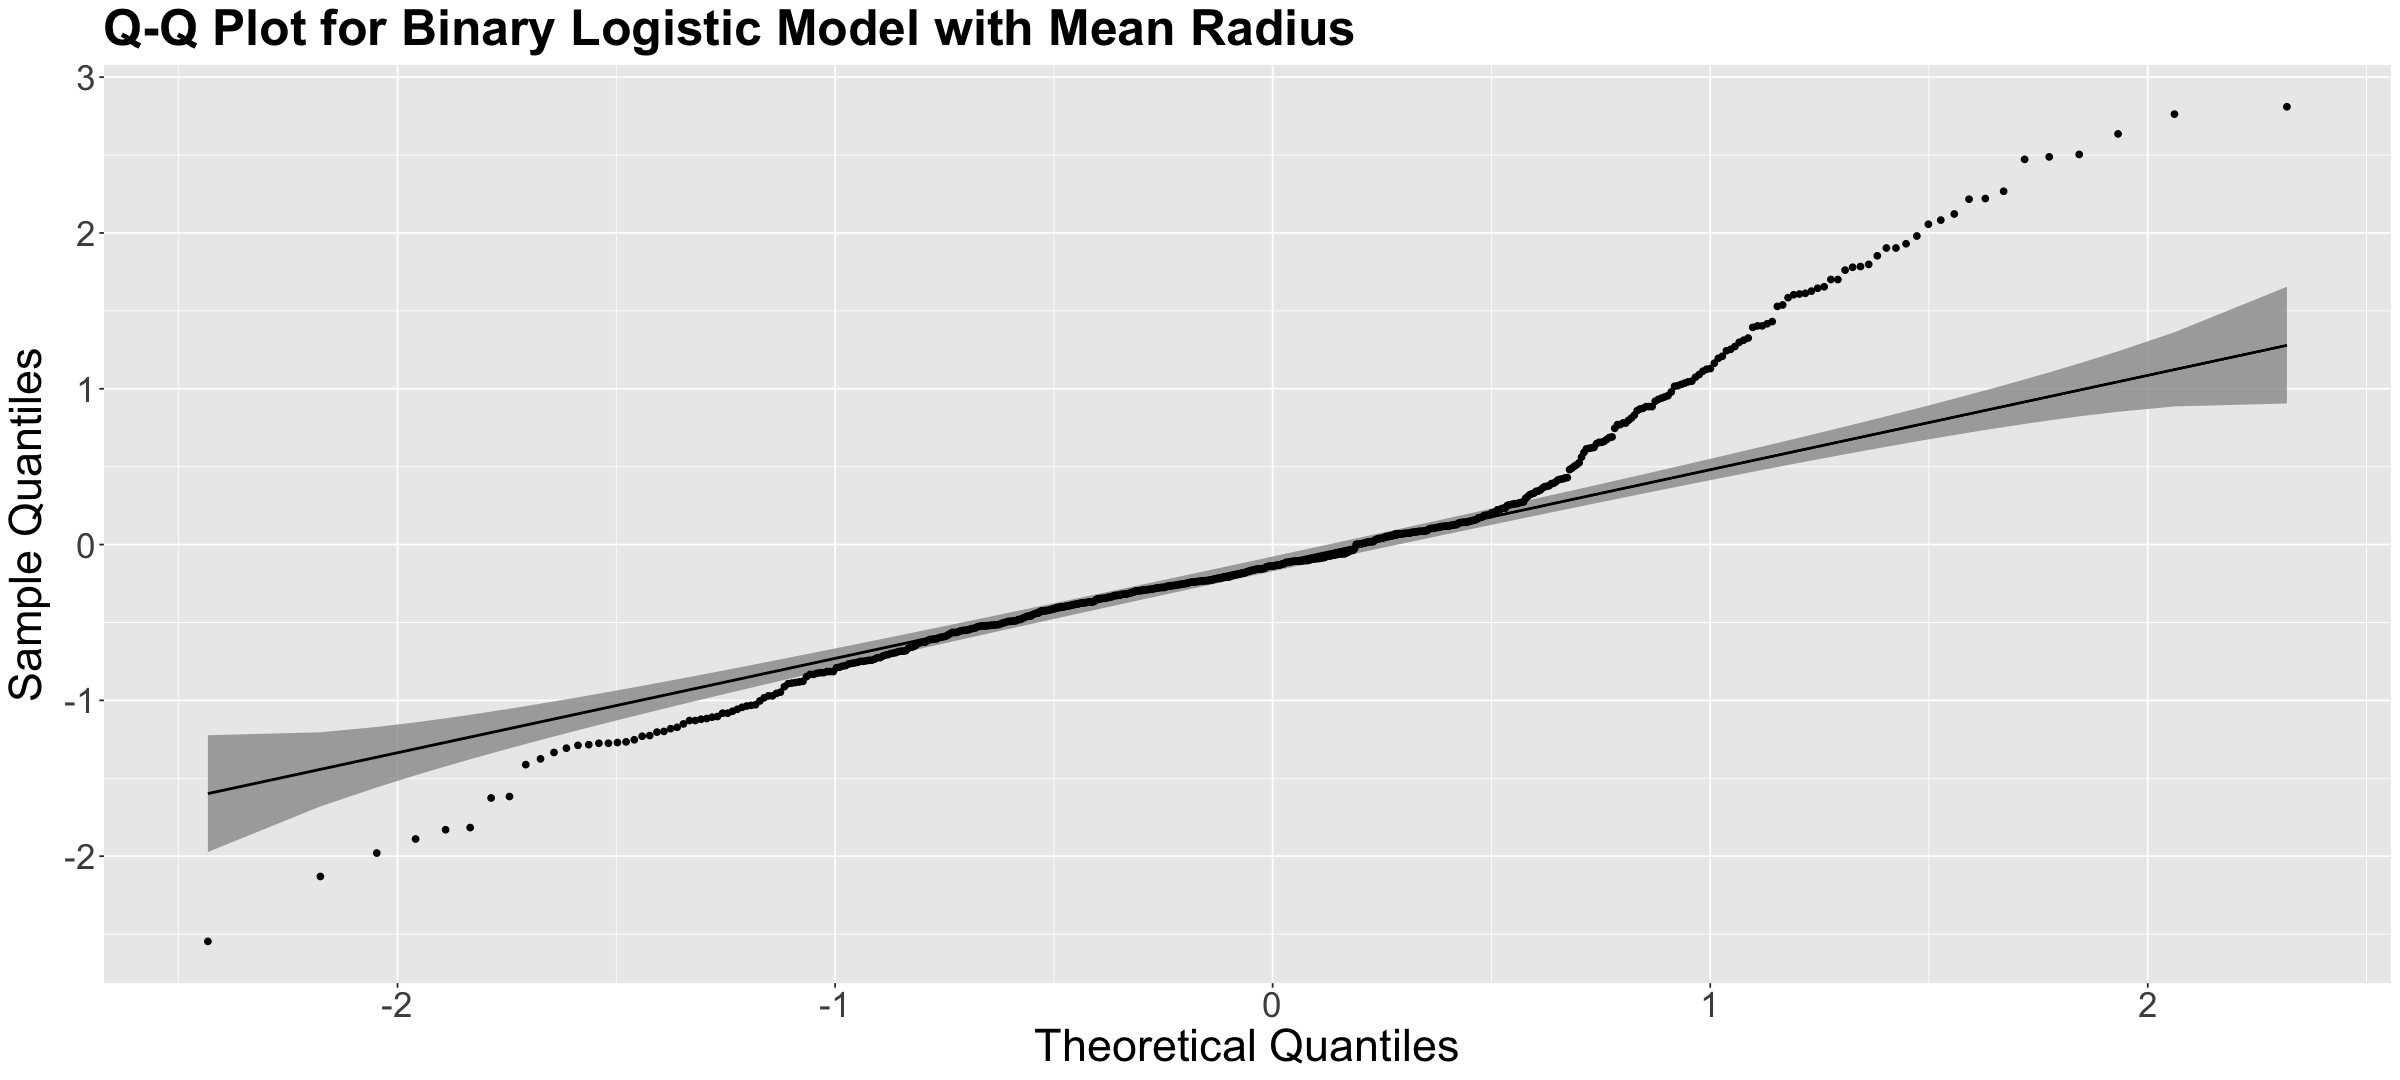

In [21]:
qqplot_dev_residuals(
  data = binary_log_model_dev_residuals,
  title = "Q-Q Plot for Binary Logistic Model with Mean Radius"
)

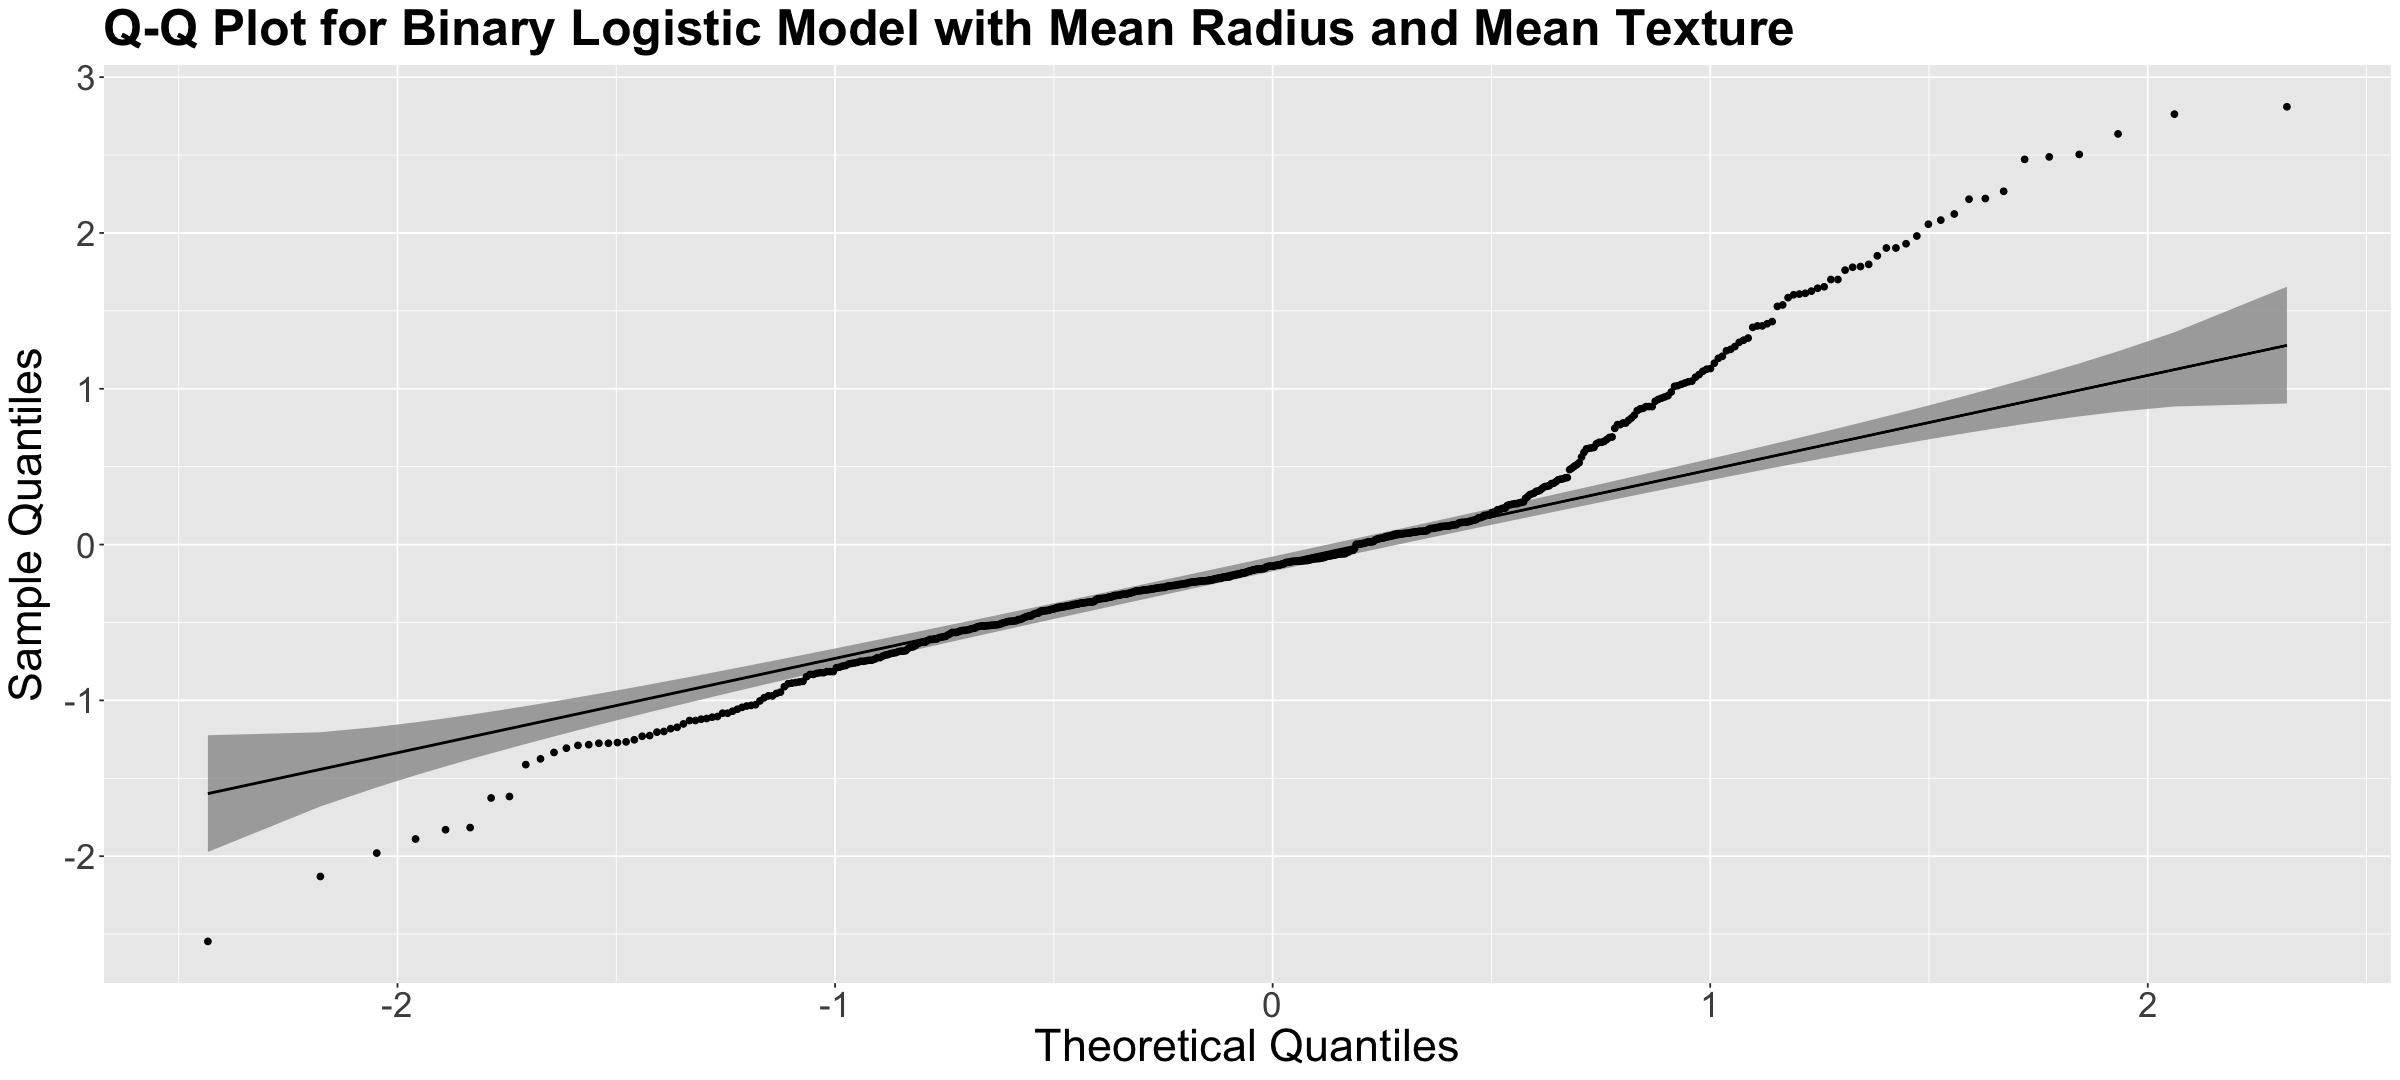

In [22]:
qqplot_dev_residuals(
  data = binary_log_model_2_dev_residuals,
  title = "Q-Q Plot for Binary Logistic Model with Mean Radius and Mean Texture"
)

### 9.2. Binned Residual Plots

A plot of **the deviance residuals $d_i$ versus fitted values $\mbox{logit}(p_i)$** (as the one below for `binary_log_model_2`) might not be too informative. This class of diagnostic plot makes sense for OLS to verify we are fulfilling **the constant variance assumption** on the random component. Nevertheless, it is not the case for Binary Logistic regression **since each response is an independent Bernoulli trial with its parameter $p_i$**.

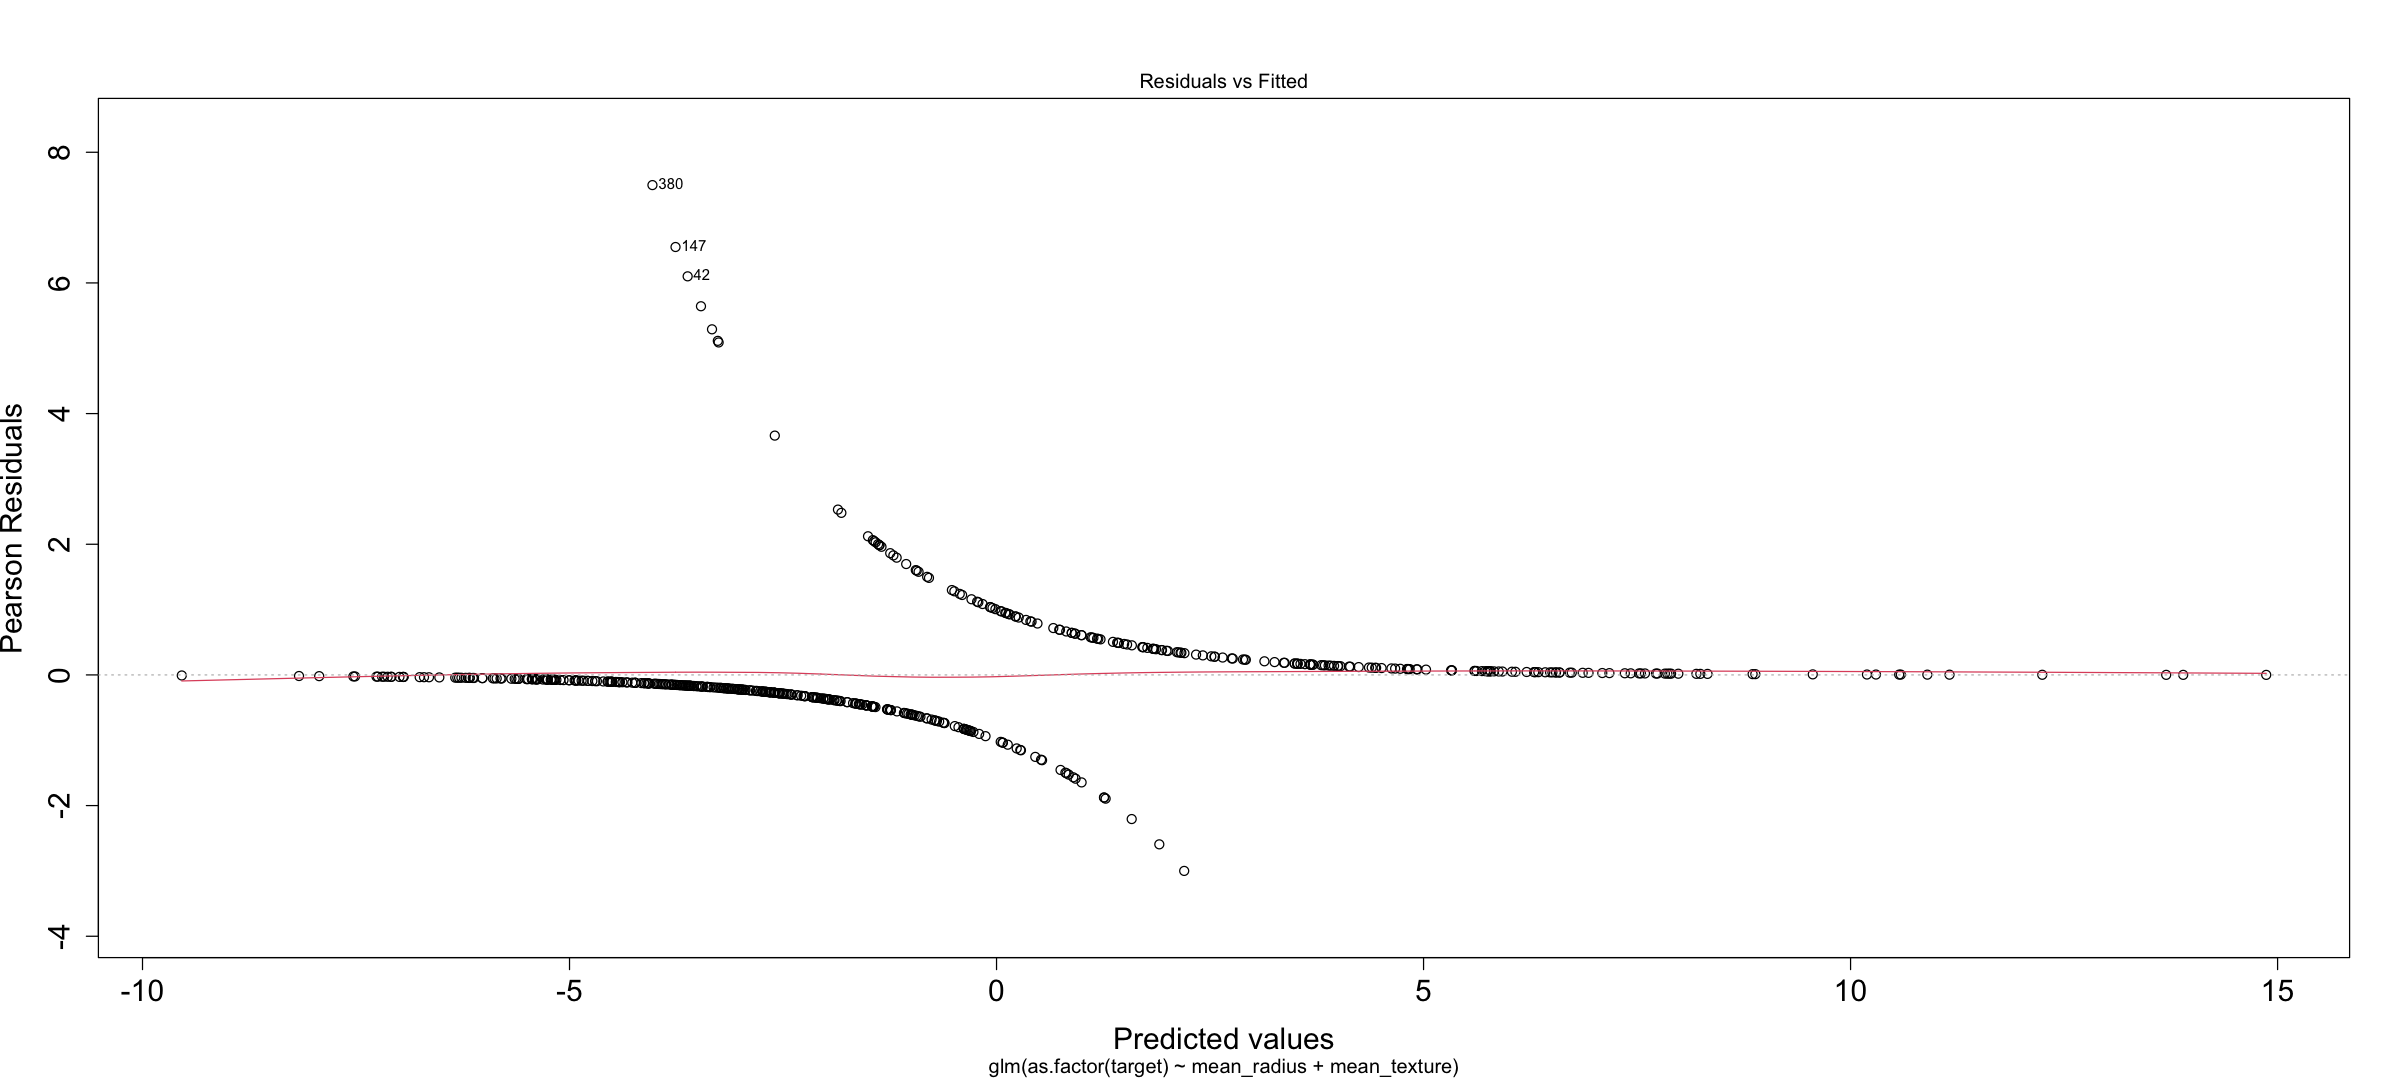

In [23]:
plot(binary_log_model_2, 1, cex.lab = 1.5, cex.axis = 1.5)

Besides deviance residuals, the Binary Logistic regression model has the $i$th **raw residual** $r_i$ as the difference between the binary observed $y_i$ and the fitted value $\hat{p}_i$:

$$
r_i = y_i - \hat{p}_i \in [-1, 1]
$$

[Gelman and Hill (2007)](http://webcat2.library.ubc.ca/vwebv/search?searchArg=Data%20analysis%20using%20regression%20and%20multilevel%2Fhierarchical%20models%20%2F&searchCode=TALL&searchType=1) recommend using **binned residual plots**. These plots are available via the package `performance` and its function `binned_residuals()`. Its argument is the fitted model as in the code below. The output is a data frame used to build the corresponding diagnostic plot.

In [24]:
diagnostic_bins <- binned_residuals(binary_log_model_2)
diagnostic_bins

,xbar,ybar,n,x.lo,x.hi,se,CI_low,CI_high,group
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
conf_int,0.0009379625,-0.04178677,23,7.190053e-05,0.001845559,0.004780543,-0.1158793,0.032305796,no
conf_int1,0.0030236387,-0.07712111,24,1.897157e-03,0.004319643,0.004275154,-0.1483579,-0.005884315,no
conf_int2,0.0054739696,-0.10450147,24,4.374413e-03,0.007189815,0.003115474,-0.1757383,-0.033264675,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
conf_int21,0.9953239,0.09486664,24,0.9918863,0.9973316,0.007948755,0.02362984,0.1661034,no
conf_int22,0.9986466,0.05095846,24,0.9976117,0.9994714,0.004327612,-0.02027833,0.1221953,no
conf_int23,0.9998101,0.01630470,24,0.9994960,0.9999997,0.004362187,-0.05493210,0.0875415,no


Then, we can obtain the binned residual plot via the function `plot()`. The resulting plot is a `ggplot` object.

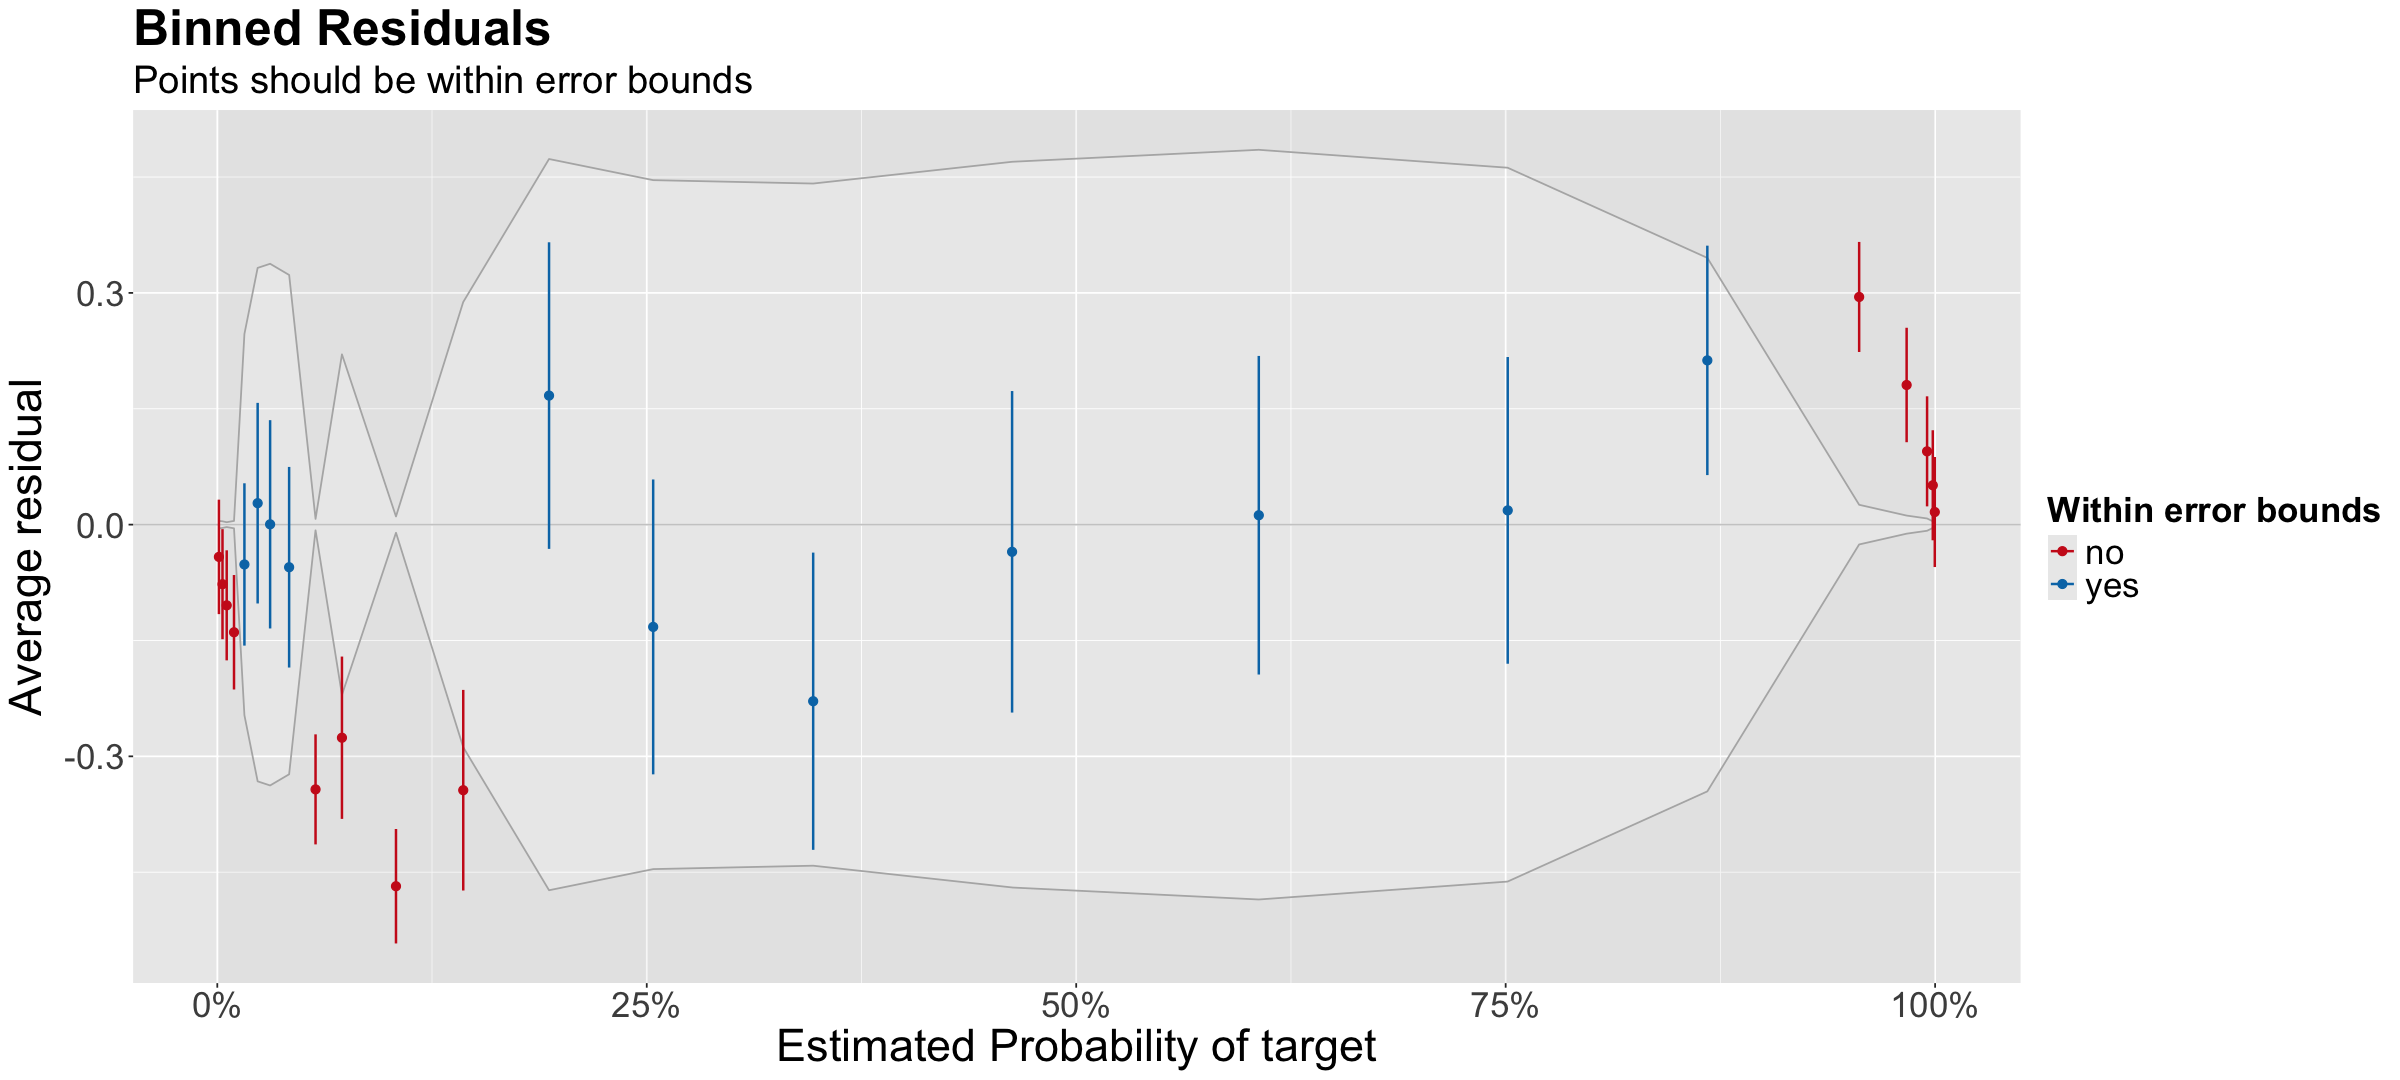

In [25]:
plot(diagnostic_bins) +
  theme(
    plot.title = element_text(size = 30, face = "bold"),
    plot.subtitle = element_text(size = 23), 
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 21),
    legend.title = element_text(size = 21, face = "bold")
  )

The plot above corresponds to `binary_log_model_2`. Function `binned_residuals()` does the following:

- **Unless specified**, the **default number of bins** is $\lceil \sqrt{n} \rceil$ as in the ceiling function: `ceiling(sqrt(n))`. For the dataset `breast_cancer` we have $n = 569$, leading to 24 bins (i.e. 24 points in the plot).
- The $n$ **fitted values** $\hat{p}_i$ are ordered from smallest to largest.
- The ordered fitted values $\hat{p}_1 < \hat{p}_2 < \dots < \hat{p}_n$ are equally split in the $\lceil \sqrt(n) \rceil$ bins.
- The respective average fitted value per bin is mapped onto the $x$-axis.
- The corresponding average raw residual $\bar{r}_j$ for the $j$th bin is mapped on the $y$-axis. Recall the $i$th raw residual is $r_i = y_i - \hat{p}_i$.
- The **95% bounds of confidence** are computed as $\pm 1.96 \times \left( \frac{s_{r_j}}{\sqrt{n_j}} \right)$ **centred at $0$ on the $y$-axis**; where $s_{r_j}$ is the **sample standard deviation** of the raw residuals in the $j$th bin with $n_j$ observations, and $1.96$ is the $97.5th$ percentile of the Standard Normal distribution.
- **One would expect to have $95\%$ of the points to be within the bounds to have a good model fit.** We can check this via the below code on column `group` in `diagnostic_bins`.

In [26]:
prop.table(table(as.factor(diagnostic_bins$group)))


       no       yes 
0.5416667 0.4583333 

Therefore, using a binned residual plot for `binary_log_model_2`, we can conclude this model is not a good for our training data.